In [295]:
import requests
import urllib
import pickle
import tqdm
from PIL import Image
import os
import numpy as np
from geopy.geocoders import GoogleV3, Nominatim
from geopy.distance import great_circle, vincenty
from IPython.display import Image, display
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def open_pkl(path):
    """Open pickle file."""
    with open(path, 'r') as picklefile:
        f = pickle.load(picklefile)
    return f

def to_pkl(path, name):
    "Pickle a file."
    with open(path, 'w') as picklefile:
        pickle.dump(name, picklefile)

In [29]:
def get_image(lat, lon):
    """Fetch google streetview image for given coordinate and save to disk."""
    url = 'http://maps.googleapis.com/maps/api/streetview?size=470x306&location=%f,%f&sensor=false' %(lat, lon)
    urllib.urlretrieve(url, 'streetview/%f,%f.jpg' %(lat, lon))
    Image('streetview/%f,%f.jpg' %(lat, lon))

In [122]:
def get_image_url(lat, lon):
    """Return google streetview image url given coordinate."""
    return 'http://maps.googleapis.com/maps/api/streetview?size=470x306&location=%f,%f&sensor=false.jpg' %(lat, lon)

### APP PIPELINE

#### Open pickled files

In [338]:
sfi = open_pkl('data/pickled/scores_for_impact_0330.pkl')

In [8]:
ssp = open_pkl('data/pickled/ss_withzip.pkl')

In [50]:
ssp.replace('no result', np.nan, inplace = True)
ssp.dropna(inplace = True)

#### 1. Get lat, lon coordinates given an address.

In [23]:
def get_coord_from_address(add, borough):
    geolocator = Nominatim()
    location = geolocator.geocode(add + ' ' + borough)
    return (location.latitude, location.longitude)

#### 2. Find closest coordinate within ssp dataset.

Split by borough.

In [93]:
boro_dict = {'bx': '005', 'bk': '047', 'mn': '061', 'qn': '081', 'si': '085' }

In [94]:
boro_dict_rev = dict(zip(boro_dict.values(), boro_dict.keys()))
ssp['boro'] = ssp.fips_tract.apply(lambda x: boro_dict_rev[x[2:5]] if x[2:5] in boro_dict_rev else np.nan)
ssp.dropna(inplace = True)

In [95]:
boro_storage = []
for b in boro_dict.keys():
    boro_storage.append(ssp[ssp.boro == b])

In [149]:
# create dictionary with keys = boroughs and values = list of coordinates in that borough
ssp_coords_boro = {}
for dfidx in range(len(boro_storage)):
    ssp_coords_boro[boro_dict.keys()[dfidx]] = zip(zip(boro_storage[dfidx].latitude, boro_storage[dfidx].longitude), boro_storage[dfidx].fips_tract)

In [103]:
# match potential borough inputs with actual borough keys
boro_match_dict = {'brooklyn': 'bk', 
                   'manhttan': 'mn', 
                   'new york': 'mn', 
                   'queens': 'qn', 
                   'staten island': 'si'}

In [12]:
ssp_coords = zip(ssp.latitude, ssp.longitude)

In [145]:
ssp_coords = zip(zip(ssp.latitude.values, ssp.longitude.values), ssp.fips_tract.values)

Functions.

In [150]:
def get_diff(zip_pair, point_pair):
    return sum((abs(zip_pair[0] - point_pair[0]), abs(zip_pair[1] - point_pair[1])))

def get_zip_diff(point, zip_list):
    distances = [(get_diff(point, p[0]), p[0]) for p[0] in coords_list]
    return min(distances)[1]

In [11]:
def get_distance(zip_pair, point_pair):
    """Get distance between two (lat, lon) pairs."""
    return vincenty(zip_pair, point_pair).miles

In [160]:
def get_shortest_distance(point, boro, coord_dict):
    """Get closet coordinate in dataset given a (lat, lon) pair. Based on distance."""
    # point = (lat, lon)
    try:
        if boro in coord_dict:
            coords_list = coord_dict[boro] # search in boro coord list
        else:
            coords_list = coord_dict[boro_match_dict[boro]] # match boro name, search in boro coord list
    except:
        coords_list = ssp_coords # if not found, use entire coord list 
    distances = [(get_diff(point, p[0]), p[0], p[1]) for p in coords_list]
    closest_coord = min(distances)[1]
    tract = min(distances)[2]
    return closest_coord, tract 

In [ ]:
get_shortest_distance()

#### 3. Show image of location and four (or X) images from random coordinates within the same census tract.

In [ ]:
def get_image_url(lat, lon):
    """Return google streetview image url given coordinate."""
    return 'http://maps.googleapis.com/maps/api/streetview?size=470x306&location=%f,%f&sensor=false.jpg' %(lat, lon)

In [135]:
ssp['coord'] = ssp.apply(lambda row: (row.latitude, row.longitude), axis = 1)

In [140]:
# create dict of coordinates for each census tract in order to find other points in that tract 
def coords_by_ct(df):
    d = {}
    grouped = df.groupby('fips_tract')
    for t, data in grouped:
        d[t] = [coord for coord in data.coord]
    return d

In [141]:
tract_coord_dict = coords_by_ct(ssp)

In [306]:
def get_random_five(tract, tract_coord_dict):
    """Choose five random points within the same census tract as a given point.
    Return list of five points and their google street view image urls."""
    coords = tract_coord_dict[tract]
    random_coords = random.sample(coords, 5)
    urls = [get_image_url(pt[0], pt[1]) for pt in random_coords]
#     return random_coords, urls
    return random_coords

Pick five random and save to dict.

In [308]:
tract_coord_dict_picked = {}
for key in tract_coord_dict:
    try:
        tract_coord_dict_picked[key] = get_random_five(key, tract_coord_dict)
    except:
        tract_coord_dict_picked[key] = tract_coord_dict[key]

In [311]:
with open('app/tract_json_picked.json', 'w') as outfile:
    json.dump(tract_coord_dict_picked, outfile)

#### 4. Show perceived safety zscore, actual danger zscore, and difference score. + other demographic data?

Clean up dfs with demographic data.

In [337]:
sfi_detailed = open_pkl('data/pickled/ssp_scores_tract_0330.pkl')

In [196]:
def clean_features(df):
    """Get df with socioeconomic and physical features (no crime scores).
    Use with sfi df. 
    """
    keep = ['fips_tract', 'median_hh_income', 'hh_type1_ht', 'median_rent',
                      'pct_hs_or_greater', 
                      'pct_male', 'median_age', 
                      'YearBuilt',
                      'race_pct_nonwhite', 
                      'hh_type_pct_nonfamily', 
                      'median_AssessTot', 'std_AssessTot', 
                      'median_NumFloors', 'std_NumFloors', 
                      'resident_density', 'worker_density', 
                      'unemp_rate', 
                      'num_311_complaints', 
                      'has_subway', 'pct_retail', 'pct_residential', 'pct_ind', 'pct_office', 'pct_other']
    return df[keep]

In [221]:
def clean_crime_scores(df):
    keep = ['fips_tract', 'crime_rate_median', 'danger_score_raw_median', 
            'danger_score_mad_from_med', 'danger_score_raw_std', 'crime_rate_mad_from_med', 
            'diff_mad_from_med', 'diff_zscore', 'n_type']
    return df[keep]

In [209]:
def tract_to_cartodb(df, path):
    df.to_csv(path, index = False)

In [339]:
sfi_clean = clean_features(sfi)
sfi_detailed_clean = clean_crime_scores(sfi_detailed)

In [340]:
sfi_master = sfi_detailed_clean.merge(sfi_clean, left_on = 'fips_tract', right_on = 'fips_tract')

In [318]:
# tract_to_cartodb(sfi_master, 'data/for_cartodb/scores_by_tract9.csv')

Normalize scores.
- don't need to normalize difference score since it's already normalized

physical features to include 
- (land use)
- median property value (median assessed tot)
- median year built/building age
- building heights
- housing affordability 

socioeconomic features
- % non family households
- % persons of color 
- median hh income
- resident density
- worker density 

In [218]:
def normalize(df, score_col, norm_col, range_start = 0, range_end = 10):
    """Normalize scores to fit within a given range.
    Args:
    df - data df
    score_col - column with unnormalized score
    norm_col - name of new column to store normalized scores
    range_start - start of the new range
    range_end - end of the new range
    """
    min_score = float(df[score_col].min())
    max_score = float(df[score_col].max())
    range_start = float(range_start)
    range_end = float(range_end)
    norm_func = lambda score: range_start + (float(score) - min_score) * (range_end - range_start) / (max_score - min_score)
    normalized = [norm_func(score) for score in df[score_col].tolist()]
    df.loc[:, norm_col] = normalized

In [225]:
# normalize(sfi_master, 'diff_zscore', 'diff_score_norm', -1, 1) don't need to 

In [232]:
medians = sfi_master.median()

crime_rate_median            8.794656e+00
danger_score_raw_median      1.327304e+01
danger_score_mad_from_med    0.000000e+00
danger_score_raw_std         4.352869e+00
crime_rate_mad_from_med      2.417771e-16
diff_mad_from_med            1.664279e-01
diff_zscore                  0.000000e+00
median_hh_income             5.240500e+04
hh_type1_ht                  4.431832e+01
median_rent                  1.228500e+03
pct_hs_or_greater            8.147779e-01
pct_male                     4.755666e-01
median_age                   3.570000e+01
YearBuilt                    1.930000e+03
race_pct_nonwhite            6.160324e-01
hh_type_pct_nonfamily        3.320537e-01
median_AssessTot             3.043200e+04
std_AssessTot                4.870721e+05
median_NumFloors             2.000000e+00
std_NumFloors                8.817732e-01
resident_density             1.652822e-03
worker_density               1.781879e-04
unemp_rate                   9.700000e+00
num_311_complaints           6.440

In [291]:
# physical features 
def get_pct_from_median(df, cols):
    newdf = df[cols]
    for c in cols: 
        newdf.loc[:,'mp_'+c] = newdf.loc[:,c].apply(lambda x: x / medians[c]) # % of median where median = 1
    newdf.loc[:,'tract'] = sfi_master.fips_tract
    newdf.loc[:,'median'] = 1
    return newdf[['tract'] + [c for c in newdf.columns if 'mp_' in c]]

In [341]:
phys_features = ['median_AssessTot', 'YearBuilt', 'median_NumFloors', 'hh_type1_ht']
phys_for_chart = get_pct_from_median(sfi_master, phys_features)

In [342]:
se_features = ['hh_type_pct_nonfamily', 'race_pct_nonwhite', 'median_hh_income', 'resident_density', 'worker_density']
se_for_chart = get_pct_from_median(sfi_master, se_features)

In [343]:
# merge into one df for export to cartodb
mp_master = phys_for_chart.merge(se_for_chart, on = 'tract')

In [344]:
mp_master = mp_master.merge(sfi_master, left_on = 'tract', right_on = 'fips_tract')

In [ ]:
# geo reference again
tract_dict = open_pkl('data/pickled/TRACT_DICT.pkl')

In [345]:
mp_master['tract_short'] = mp_master.fips_tract.apply(lambda x: tract_dict[x])

In [347]:
tract_to_cartodb(mp_master, 'data/for_cartodb/features_mp3.csv')

#### some additional stuff
- normalize danger score 
- round numbers
- get land use sf

In [349]:
# normalize raw danger score between 0 and 10
normalize(mp_master, 'danger_score_raw_median', 'danger_score_raw_median_norm', 0, 10)

In [ ]:
# round numbers to 1 decimal place
def round_nums(df, to_round, places):
    for col in to_round:
        df[col + '_r'] = df[col].round(places)

round_nums(mp_master, ['diff_zscore', 'danger_score_raw_median_norm'], 1)
round_nums(mp_master, ['crime_rate_median'], 0)

In [370]:
# add actual sf numbers
sf = open_pkl('data/pickled/sf_breakdown.pkl')

In [371]:
mp_master = mp_master.merge(sf, how = 'left', on = 'tract')

In [372]:
mp_master.head()

tract  mp_median_AssessTot  mp_YearBuilt  mp_median_NumFloors  \
0  36005000200             0.595426      1.005181                    1   
1  36005000400             0.670347      1.015544                    1   
2  36005001600             0.725601      1.015544                    1   
3  36005001900             3.430599      1.000518                    1   
4  36005002000             0.760055      1.002591                    1   

   mp_hh_type1_ht  mp_hh_type_pct_nonfamily  mp_race_pct_nonwhite  \
0        1.031700                  0.465165              1.093853   
1        1.061105                  0.591054              1.150975   
2        0.836063                  0.938750              1.149222   
3        0.858865                  1.321620              1.101614   
4        0.722274                  0.790282              1.229616   

   mp_median_hh_income  mp_resident_density  mp_worker_density    ...      \
0             1.428051             0.610395           0.056674    ...       
1             1.488236             0.394220           0.203441    ...       
2             0.617384             0.627119           0.621253    ...       
3             0.660910             0.086521           1.770043    ...       
4             0.446961             1.269210           0.173459    ...       

  danger_score_raw_median_norm  danger_score_raw_median_r  \
0                     3.027789                       13.2   
1                     4.107566                       14.9   
2                     4.007915                       14.7   
3                     6.939991                       19.3   
4                     2.936865                       13.1   

   danger_score_raw_median_norm_r  diff_zscore_r  crime_rate_median_r  \
0                             3.0           -0.7                    7   
1                             4.1           -1.7                    6   
2                             4.0            1.0                   26   
3                             6.9           -3.1                    9   
4                             2.9            0.9                   13   

   ResArea  OfficeArea  RetailArea ind_area  OtherArea  
0  1604000        1400       20610    38615      16000  
1  2174617       58752       23845    38907     174562  
2  2171289      293885       19842     9710    1255901  
3  1084326      469276      117241  5670797     178227  
4  2734798       20266       59703        0     190749  

[5 rows x 53 columns]

In [377]:
new_stuff_to_merge = mp_master[['tract', 'danger_score_raw_median_norm_r', 'diff_zscore_r', 'crime_rate_median_r', 
                      'ResArea', 'OfficeArea', 'RetailArea', 'ind_area', 'OtherArea']]

In [379]:
tract_to_cartodb(new_stuff_to_merge, 'data/for_cartodb/roundedstuff_0330.csv')

In [380]:
# new features; se, physical: building height variance instead of building height, 311 complaints

Index([u'tract', u'mp_median_AssessTot', u'mp_YearBuilt',
       u'mp_median_NumFloors', u'mp_hh_type1_ht', u'mp_hh_type_pct_nonfamily',
       u'mp_race_pct_nonwhite', u'mp_median_hh_income', u'mp_resident_density',
       u'mp_worker_density', u'fips_tract', u'crime_rate_median',
       u'danger_score_raw_median', u'danger_score_mad_from_med',
       u'danger_score_raw_std', u'crime_rate_mad_from_med',
       u'diff_mad_from_med', u'diff_zscore', u'n_type', u'median_hh_income',
       u'hh_type1_ht', u'median_rent', u'pct_hs_or_greater', u'pct_male',
       u'median_age', u'YearBuilt', u'race_pct_nonwhite',
       u'hh_type_pct_nonfamily', u'median_AssessTot', u'std_AssessTot',
       u'median_NumFloors', u'std_NumFloors', u'resident_density',
       u'worker_density', u'unemp_rate', u'num_311_complaints', u'has_subway',
       u'pct_retail', u'pct_residential', u'pct_ind', u'pct_office',
       u'pct_other', u'tract_short', u'danger_score_raw_median_norm',
       u'danger_score_raw_

In [389]:
# get mp for 311 complaints
last_features = sfi[['fips_tract', 'num_311_complaints', 'std_NumFloors']]
last_features = get_pct_from_median(last_features, ['num_311_complaints', 'std_NumFloors'])

In [392]:
tract_to_cartodb(last_features, 'data/for_cartodb/last_features330.csv')

#### 5. Search for neighborhoods with similar scores and demographic data.

#### 6. Test full run

NEED TO PICKLE
- ssp_coords_boro
- ssp_coords
- boro_match_dict (not necessary pickle, just have in file)
- tract_coord_dict

or just put in sql and run queries?

In [303]:
import json
tract_dict_json = json.dumps(tract_coord_dict)

In [174]:
def run_app(add, borough):
    # get coord given string address
    search_coord = get_coord_from_address(add, borough)
    
    # find closest coord in ss data
    closest_coord, tract = get_shortest_distance(search_coord, borough, ssp_coords_boro)
    
    # get url for sv image
    url = get_image_url(closest_coord[0], closest_coord[1])
    
    # display image 
    display(Image(url))
    
    # get five random pts/images
    random_coords, five_urls = get_random_five(tract, tract_coord_dict)
    
    # display five random images
    for url in five_urls:
        display(Image(url))

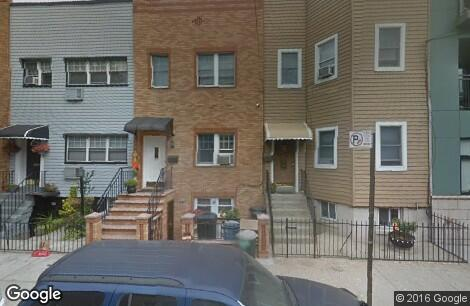

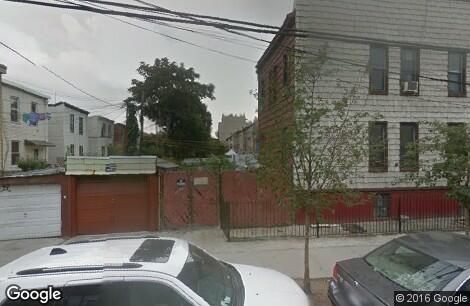

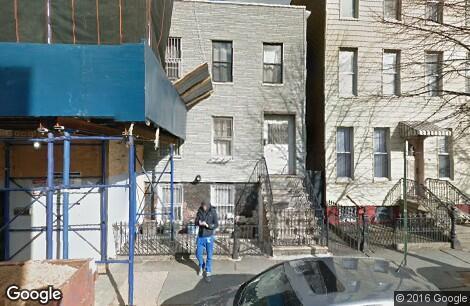

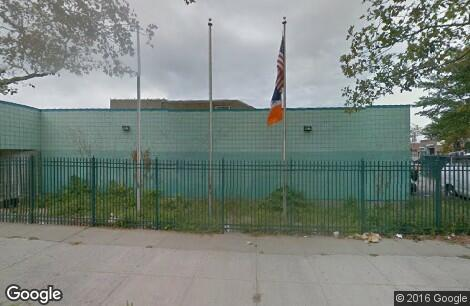

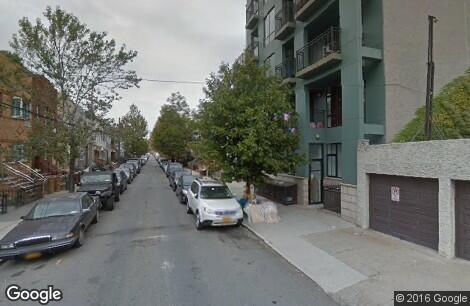

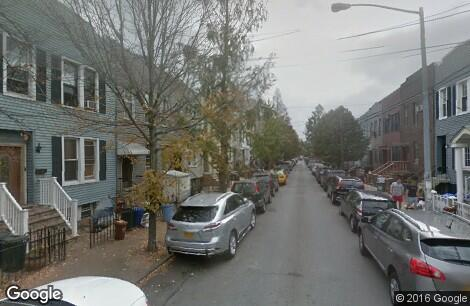

CPU times: user 179 ms, sys: 105 ms, total: 283 ms
Wall time: 4.36 s


In [202]:
%time run_app('138 diamond st', 'brooklyn')